In [1]:
#!pip install tensorflow==2.14.0

## This is a Coiab notebook!

# End-to-end Multi-class Dog Breed Classification

This note builds an end-to-end multi-class image classifier using TensorFlow and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a photo fo a dog, I want to know what breed of dog it is.

## 2. Data

The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is file with prediction probabilities for each dog breed for each test image.

https://www.kaggle.com/c/dog-breed-identification/overview

## 4. Features

Some information about the data:
* we're dealing with images (unstructured data) so it's probably best we use deep learnin/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes)
* There are around 10,000+ images in the training set
(these images have label)
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).

In [2]:
# Unzip the uploaded data into google drive
#!unzip "/content/drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision/"

### Get our workspace ready
* Import TensorFlow 2.x (`DONE`)
* Import TensorFlow Hub (`DONE`)
* Make sure we're using a GPU (`DONE`)


In [3]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras as keras
print("TF version",tf.__version__)
print("TF Hub version", hub.__version__)

# Check for GPU availability
print("GPU","available(YES!!!!!!)" if tf.config.list_physical_devices("GPU") else "not available")

2024-08-06 08:25:53.476940: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 08:25:53.477048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 08:25:53.647123: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TF version 2.15.0
TF Hub version 0.16.1
GPU available(YES!!!!!!)


## Getting our data ready tunning into (Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representation)   

Let's start by accessing our data and checking out the labels.

In [4]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("/kaggle/input/drive-02/MyDrive/Dog Vision/dog-breed-identification/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [5]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

<Axes: xlabel='breed'>

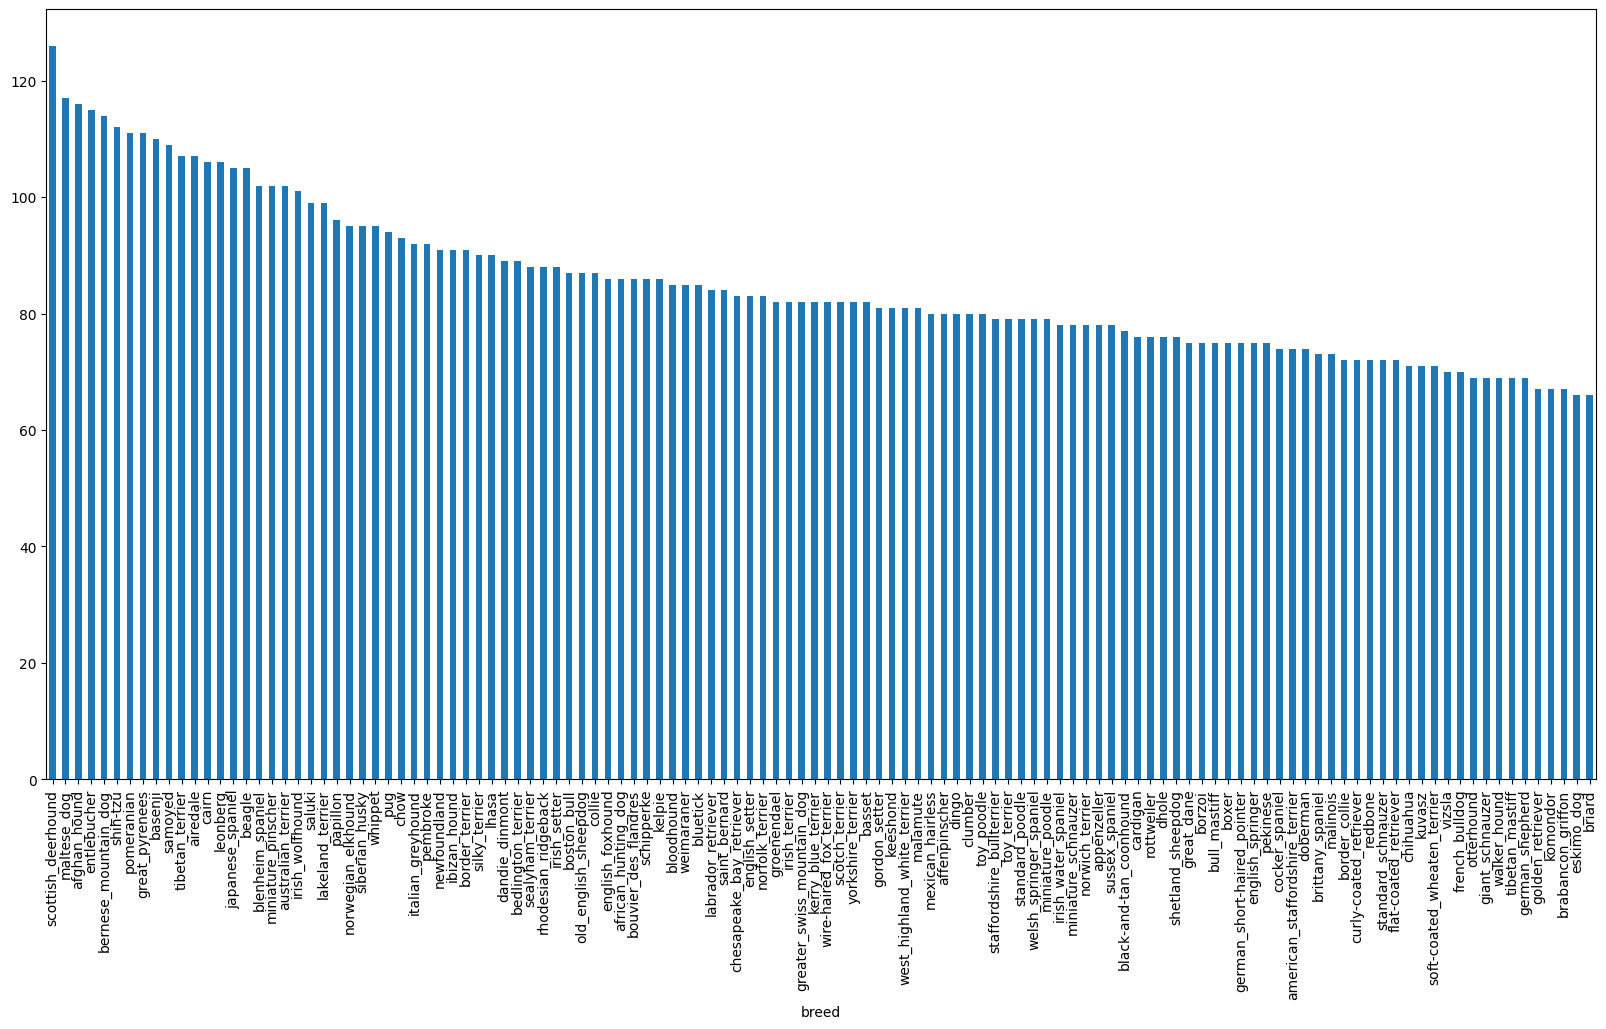

In [6]:
# How many images are there of each class
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [7]:
labels_csv["breed"].value_counts()<10 # minimum ten images for each class

breed
scottish_deerhound      False
maltese_dog             False
afghan_hound            False
entlebucher             False
bernese_mountain_dog    False
                        ...  
golden_retriever        False
komondor                False
brabancon_griffon       False
eskimo_dog              False
briard                  False
Name: count, Length: 120, dtype: bool

### All classes have more than 10 images

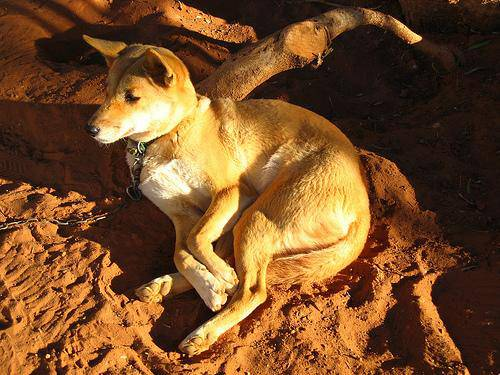

In [8]:
# Let's view an image
from IPython.display import Image
Image("/kaggle/input/drive-02/MyDrive/Dog Vision/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels

Let's get a list of all our image file pathnames

In [9]:
# Create pathname from image ID's
filename = ["/kaggle/input/drive-02/MyDrive/Dog Vision/dog-breed-identification/train/"+fname+".jpg" for fname in labels_csv["id"]] # creates a list of 'fname' from 'fname' which gets the values from 'labels_csv["id"]'


filename

['/kaggle/input/drive-02/MyDrive/Dog Vision/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/kaggle/input/drive-02/MyDrive/Dog Vision/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/kaggle/input/drive-02/MyDrive/Dog Vision/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/kaggle/input/drive-02/MyDrive/Dog Vision/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/kaggle/input/drive-02/MyDrive/Dog Vision/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/kaggle/input/drive-02/MyDrive/Dog Vision/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/kaggle/input/drive-02/MyDrive/Dog Vision/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/kaggle/input/drive-02/MyDrive/Dog Vision/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/kaggle/input/drive-02/MyDrive/Dog Vision/dog-breed-identification/train/003df8b8a8b05

In [10]:
# Check whether number of filenames matches number of actual image files.
import os
if len(os.listdir("/kaggle/input/drive-02/MyDrive/Dog Vision/dog-breed-identification/train/")) == len(filename):
  print("Filenames match actual amount of files!!! Proceed")
else:
  print("Filenames do not match actual amount of files, check the targt directory.")

Filenames match actual amount of files!!! Proceed


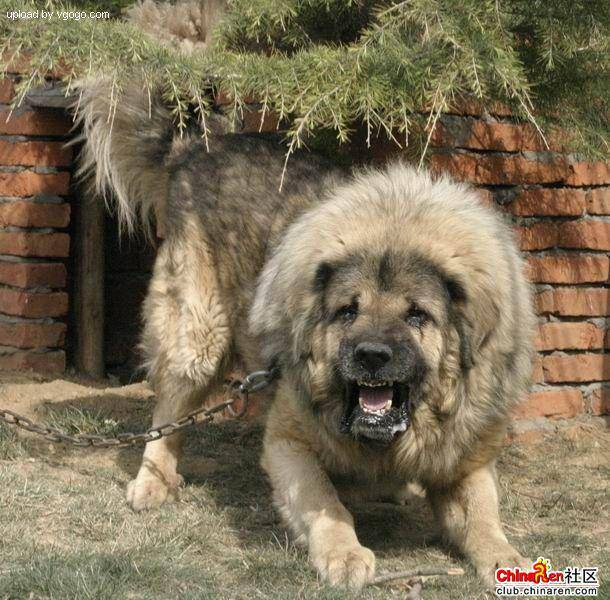

In [11]:
Image(filename[9000])

In [12]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in a list, let's prepare our labels.

In [13]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array["labels"] #does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [14]:
len(labels)

10222

In [15]:
# See if number of labels matches the number of filenames
if len(labels) == len(filename):
  print("Number of labels matches number of filenames!!")
else:
  print("Number of labels does not match number of ilenames, check data directories")


Number of labels matches number of filenames!!


In [16]:
# Find the unique labels values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [17]:
len(unique_breeds)

120

In [18]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [19]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

### Basically, we have done something similar to introducing a column for each unique breed and checked for each value in labels to which `column(breed` does it belong. We place there `True(1)(Found)` or `False(1)(Not Found)`

In [20]:
np.shape(boolean_labels)

(10222, 120)

In [21]:
# Example: Turning boolean array into integers
print(labels[0]) # Original lable
print(np.where(unique_breeds==labels[0])) # Index where lbael occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

Since the dataset from Kaggle doesn't come with validation set, we're going to create our own

In [22]:
# Setup X & y variabls
X = filename
y = boolean_labels

We're going to start off experimenting with ~1000 images and increase as needed.

In [23]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 ##param {type:"slider", min:1000, max:10000, step:1000}

In [24]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train,X_val,y_train,y_val = train_test_split(X[:NUM_IMAGES],y[:NUM_IMAGES],test_size=.2,random_state=42)

len(X_train),len(y_train),len(X_val),len(y_val)

(800, 800, 200, 200)

In [25]:
# Let's have a gees at the training data
X_train[:5], y_train[:5]

(['/kaggle/input/drive-02/MyDrive/Dog Vision/dog-breed-identification/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/kaggle/input/drive-02/MyDrive/Dog Vision/dog-breed-identification/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  '/kaggle/input/drive-02/MyDrive/Dog Vision/dog-breed-identification/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  '/kaggle/input/drive-02/MyDrive/Dog Vision/dog-breed-identification/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  '/kaggle/input/drive-02/MyDrive/Dog Vision/dog-breed-identification/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,

### Preprocessin images (turning images into Tensors)

To preprocess our images into Tesnsors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1).
5. Resize the `image` to be a shape of (224,224)
6. Reutrn the modified `images`

Before we do, let's see what importing an image looks like

In [26]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filename[42])
image.shape

(257, 350, 3)

In [27]:
image[:2]

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)

In [28]:
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  5

Now we've seen what an image looks like as a Tensor. Let's make a function to preprocess them.

In [29]:
# Define image size
IMG_SIZE = 224 # our machine learning model was trained on 224 by 224 size images so we have to feed it same size of images

# Create a function for preprocession images
def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Reads the image file into a raw byte stream.
  # This is necessary because image files can be in various formats (e.g., JPEG, PNG),
  # and reading the raw bytes allows us to handle the image data regardless of its format.
  image = tf.io.read_file(image_path)
  # The raw byte stream is binary data that represents the image file but does not directly provide visual content.
  # Decode the JPEG image from the raw byte stream into a numerical Tensor with 3 color channels (Red, Green, Blue).
  # This converts the raw bytes into a tensor where each pixel is represented by its RGB values.
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert the color channel values from the range 0-255 to the range 0-1.
  # This normalization helps in standardizing the input data for better performance during model training.
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is batch size) images at a time (you can manually adjust the batch size if need be.)

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: `(image,lbael)`

In [30]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
    Takes an image file path and the associated label,
    processes the image and returns a tuple of (image, label).

    Args:
        image_path (str): File path to the image.
        label (int or str): The label associated with the image.

    Returns:
        tuple: A tuple containing the processed image and the label.
               - Processed image: A tensor representing the image after preprocessing.
               - Label: The label associated with the image.
    """
  image = process_image(image_path)
  return image, label

In [31]:
# Demo of above
(process_image(X[42]),tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors int the format `(Image, label)`, let's make a function to turn all of our data (`X`&`y`) into batches

In [82]:
# Define the batch size, 32 is a  good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X,y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data ur of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print(" Creating test data batches...")
    # Create a Dataset where each element is a row (slice) from the tensor X
    # For example, if X = [[10, 20], [30, 40], [50, 60]],
    # the dataset will have elements:
    #  Element 1: [10, 20]
    #  Element 2: [30, 40]
    #  Element 3: [50, 60]
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    # Apply the process_image function to each file path in the dataset "(data)" to preprocess the images (read, decode, normalize, and resize).
    # After preprocessing, group the processed images into batches of size BATCH_SIZE.
    #
    # For example, if BATCH_SIZE = 4 and the dataset contains 10 images, then:
    # - DataBatch will contain batches like this:
    #   - Batch 1: [processed_image1, processed_image2, processed_image3, processed_image4]
    #   - Batch 2: [processed_image5, processed_image6, processed_image7, processed_image8]
    #   - Batch 3: [processed_image9, processed_image10]
    #
    # Each batch contains 4 images, and batching helps in processing multiple images at once during model training.
    data_batch = data.map(process_image).batch(batch_size)
    return data_batch

    # If the data is valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y)))# labels
    # Applies the `get_image_label` function to each element in the dataset `data`.
    # This function processes the image file path and label, returning a tuple of (processed_image, label).
    # After processing, the dataset is grouped into batches of size defined by the variable `batch_size`.
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))
    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch

In [33]:
# Create training and validatino data batches
train_data = create_data_batches(X_train,y_train)
val_data = create_data_batches(X_val,y_val,valid_data=True)

Creating training data batches...
Creating validation data batches...


In [34]:
# Check out the different attributes of our data batches
train_data.element_spec,val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

 What we get is a tuple where:
 - The first element represents the image:
   - Shape: `(None, 224, 224, 3)`.
     - `None` denotes that the batch size is flexible and can vary.(althoug it is 32 in our case)
    - `224, 224` are the height and width of the images.
    - `3` indicates the number of color channels (RGB).
   - Data type: `tf.float32`.

 - The second element represents the label:
   - Shape: `(None, 120)`.
     - `None` denotes that the batch size is flexible.
     - `120` represents the number of classes (in this case, a one-hot encoded label vector for classification).
   - Data type: `tf.bool`.

 In summary, for both `train_data` and `val_data`, each batch is a tuple of `(image, label)`, where:
 - `image` is a tensor with shape `(batch_size, height, width, color_channels)`.
 - `label` is a tensor with shape `(batch_size, number_of_classes)`.

## Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to understand/comprehend, let's visualize them

In [35]:
import matplotlib.pyplot as plt

# Create a function for viewing images ina data batch
def show_25_image(image,labels):
  """
  Displays a plot of 25 images and their labels froma data batch.
  """
  # setup the figure
  plt.figure(figsize=(10,10))
  # Loop through 25 (for displaying images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5,5,i+1)
    # Display an image
    plt.imshow(image[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()]) # labels have the information to which breed each image belongs to
    # labels[i].argmax() returns the index which is then used as an index in unique_breeds
    # which returns the name of the breed

    # Turn the grid lines off
    plt.axis("off")


In [36]:
# Create an iterator from the `train_data` dataset, which yields batches of data as NumPy arrays.
# basically converts the our tensor type data to Numpy for easy data manipulation
# `train_data` contains pairs of (image, label) tensors that have been preprocessed and batched.
iterator = train_data.as_numpy_iterator()

# Retrieve the first batch of data from the iterator.
# The batch consists of:
# - `train_images`: NumPy array of shape (batch_size, IMG_SIZE, IMG_SIZE, 3)
#   - Represents a batch of processed images, resized to (IMG_SIZE, IMG_SIZE) with 3 color channels (RGB).
# - `train_labels`: NumPy array of shape (batch_size, number_of_classes)
#   - Represents the corresponding labels for the images, typically in a one-hot encoded format.
train_images, train_labels = next(iterator)
train_images, train_labels

(array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
 
         [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
 
         [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [0.00000000e+00, 0.00000000e+00, 0.0000

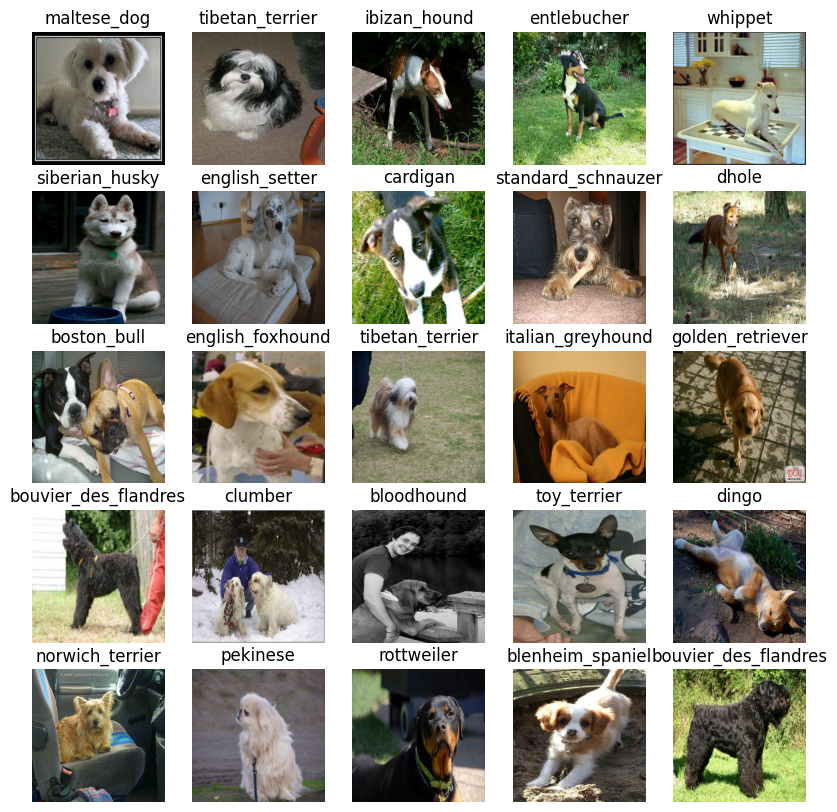

In [37]:
# Now let's visualize the data in a training data
show_25_image(train_images, train_labels)

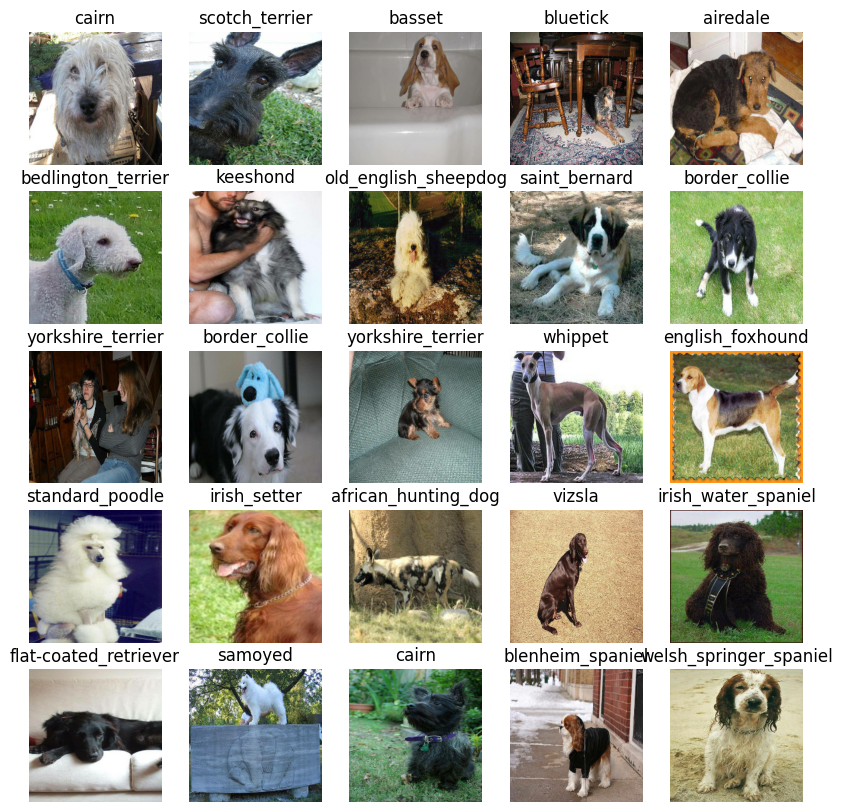

In [38]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_image(val_images,val_labels)

## Building a model

Before we build a model, there are a few things we need to define
1. The input shape (our images shape, in the form of Tensors) to ur model.
2. The ouput shape (image lbales, in the form of Tensors) of our model.
3. The URL of the model we want to use from Kaggle:
 https://www.kaggle.com/models/google/mobilenet-v2/tensorFlow2/130-224-classification/1?tfhub-redirect=true

In [39]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds) # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"


Now we've got our inputs, outputs and model ready to go.

Let's put them together into a keras deep learning model!

Knowing this, let's create a function which:
* Takes the input shpae, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in suquential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting)
* Returns the model

In [40]:
import tensorflow as tf
import tensorflow_hub as hub
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = keras.Sequential([
        # Layer 1: Input layer using a pre-trained model from TensorFlow Hub
        # This layer will handle the feature extraction
        hub.KerasLayer(model_url),
        # Layer 2: Output layer
        # Dense layer with the number of units equal to the number of output classes
        # Softmax activation function converts the output to a probability distribution
        # each output value is transformed into a probability between 0 and 1.
        # The sum of all output probabilities will always be equal to 1.
        keras.layers.Dense(units=output_shape, activation="softmax")
    ])

  # Compile the model
  # The model.compile function indeed sets up the configuration for training and evaluation.
  # It defines how the model should compute the loss,
  # how it should adjust its weights
  # what metrics should be tracked during training and evaluation.
  model.compile(
    # Specifies the loss function to be minimized during training
    # CategoricalCrossentropy computes the difference between predicted probabilities and true labels (one-hot encoded)
    loss=keras.losses.CategoricalCrossentropy(),

    # Specifies the optimizer to update the model’s weights based on the loss function
    # Adam optimizer adapts learning rates and uses momentum for more efficient weight updates
    optimizer=keras.optimizers.Adam(),

    # Specifies the metrics to evaluate model performance
    # Accuracy measures the proportion of correctly predicted labels out of all predictions
    metrics=["accuracy"]
  )

  # Build the model
  # Initializes the model with the specified input shape
  # INPUT_SHAPE defines the shape of the input data, including the batch size (None means variable batch size)
  # For example, if INPUT_SHAPE is (None, 224, 224, 3):
  # - None represents the batch size, allowing for variable numbers of samples in a batch
  # - (224, 224, 3) represents the shape of each individual input image (height, width, and color channels)
  # This setup informs the model about the shape of incoming data and allows it to allocate necessary resources
  model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting

  return model

In [41]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


## Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress, or stop training early if it's not improving.

We'll create two callbacks, one for TensorBoard which  helps track our model progress and another for early stoping which prevents our model from training for too long.

### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension (Done)
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our models `fit()` function.
3. Visualize our models training logs with the `%tensorboard` magic function (well do this after model training)


In [42]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [43]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
    """
    Creates a TensorBoard callback instance for logging training metrics.
    """
    # Create a log directory for storing TensorBoard logs
    # The log directory path combines a base path with a timestamp to ensure unique log directories for each run
    logdir = os.path.join("/kaggle/working/logs", 
                          # Make it so the logs get tracked whenever we run an experiment
                          # Create a timestamp in the format YearMonthDay-HourMinuteSecond for uniqueness
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    # Create the log directory if it does not exist
    os.makedirs(logdir, exist_ok=True)
    
    # Return a TensorBoard callback instance
    # The TensorBoard callback will log training metrics to the specified log directory
    return keras.callbacks.TensorBoard(log_dir=logdir)

### Early Stopping Callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving

In [44]:
# Create early stopping callback
# The EarlyStopping callback monitors a specified metric during training and stops
# the training process if that metric stops improving.
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",  # Monitor the validation accuracy
    patience=3  # Number of epochs with no improvement after which training will be stopped
)


## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working

In [45]:
NUM_EPOCHS = 100 #@param {type:"slider",min:10,max:100,step:10}

In [46]:
# Check to make sure we're still running on a GPU
print("GPU","available" if tf.config.list_physical_devices("GPU") else "not available")

GPU available


Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training dat, validation dat, number of epochs to train for {`NUM_EPOCHS`} and the callbacks we'd like to use
* Return the model

In [47]:
# Build a function to train and returna trained model
def train_model():
    """
    Trains a given model and returns the trained version.
    """
    # create a model 
    model = create_model()
    
    # Create a new TensorBoard session everytime we train a model
    tensorboard = create_tensorboard_callback()
    
    # Fit the model to the data passing it the callbacks we created
    model.fit(x=train_data,
             epochs=NUM_EPOCHS,
             validation_data=val_data,
             validation_freq=1,
             callbacks=[tensorboard,early_stopping])
    # Return the fitted model
    return model

In [48]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100


I0000 00:00:1722932806.897539     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 [==============================] - 29s 143ms/step - loss: 4.5983 - accuracy: 0.1000 - val_loss: 3.5486 - val_accuracy: 0.2500
Epoch 2/100
25/25 [==============================] - 1s 58ms/step - loss: 1.6178 - accuracy: 0.6925 - val_loss: 2.2758 - val_accuracy: 0.4850
Epoch 3/100
25/25 [==============================] - 1s 58ms/step - loss: 0.5804 - accuracy: 0.9325 - val_loss: 1.7675 - val_accuracy: 0.5750
Epoch 4/100
25/25 [==============================] - 1s 58ms/step - loss: 0.2536 - accuracy: 0.9837 - val_loss: 1.5974 - val_accuracy: 0.6150
Epoch 5/100
25/25 [==============================] - 1s 57ms/step - loss: 0.1500 - accuracy: 0.9950 - val_loss: 1.5012 - val_accuracy: 0.6250
Epoch 6/100
25/25 [==============================] - 1s 58ms/step - loss: 0.1021 - accuracy: 0.9975 - val_loss: 1.4505 - val_accuracy: 0.6250
Epoch 7/100
25/25 [==============================] - 1s 58ms/step - loss: 0.0758 - accuracy: 1.0000 - val_loss: 1.4170 - val_accuracy: 0.6350
Epoch 8/100
25/2

**Questino:** It looks like our model is overfitting because its performing far better on the training dataset than the validation dataset, what are some ways to prevent model overfitting in deep learning neural networks

**Note:** Overfitting to begin with is a good thing! it means our model is learning!!!

### Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize its contents

In [49]:
%load_ext tensorboard
%tensorboard --logdir /kaggle/working/logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Making and evaluating predictions using a trained model


In [50]:
# Make predictions on the validation data (which includes both images and labels, but only images are used for prediction)
predictions = model.predict(val_data, verbose=1)
# 'predictions' now contains the model's predicted probabilities for each class for each image in the validation dataset
# The 'verbose=1' argument provides a progress bar to show the prediction process
predictions

7/7 [==============================] - 1s 53ms/step


array([[2.98540620e-03, 2.99935957e-04, 7.82559218e-04, ...,
        1.85998753e-04, 3.98173543e-05, 7.30717788e-03],
       [9.14629491e-04, 3.64727079e-04, 2.86702695e-03, ...,
        1.06323336e-04, 1.64496293e-03, 6.74283874e-05],
       [1.48373592e-05, 9.60716628e-04, 1.71392239e-05, ...,
        4.10090906e-05, 4.59859002e-05, 1.93089712e-04],
       ...,
       [7.93673371e-06, 3.10829928e-05, 8.59741194e-05, ...,
        1.25954039e-05, 1.98049038e-05, 3.05007252e-05],
       [9.19378735e-03, 2.31339727e-04, 1.53663146e-04, ...,
        2.20346075e-04, 7.56203299e-05, 1.30214160e-02],
       [6.64896797e-04, 3.25930559e-05, 5.13005361e-04, ...,
        3.12337875e-02, 1.19993938e-02, 7.60499461e-05]], dtype=float32)

In [51]:
predictions.shape # As there are 120 unique species 
# so predictions variable consiste of probabilities for all the species
# that our model thinks each sample is
# the  higher probability of one of the speicie for a specifice sample means 
# our model thinks that the sample belongs to that specifice specie

(200, 120)

In [52]:
# First prediction
index = 42
print(predictions[0])
print(f"Max value (probability of prediction):{np.max(predictions[index])}")
print(f"Sum:{np.sum(predictions[index])}")
print(f"max index:{np.argmax(predictions[index])}")
print(f"predicted label:{unique_breeds[np.argmax(predictions[index])]}")

[2.9854062e-03 2.9993596e-04 7.8255922e-04 1.6005868e-04 7.0541911e-04
 1.5739353e-05 6.7875609e-02 2.2082466e-04 1.5014528e-05 5.0375349e-04
 3.8961443e-04 8.8121989e-05 6.1423134e-04 6.7122266e-05 4.1203827e-04
 9.7625173e-04 2.0860812e-04 3.5015726e-01 2.5611258e-05 2.1878996e-05
 3.8701232e-04 6.1962608e-05 7.9798156e-06 1.1671491e-03 2.8476783e-05
 3.4066668e-04 6.8330988e-02 2.3279850e-05 6.8825495e-04 1.5443923e-04
 4.5343018e-05 2.1053208e-03 3.6724535e-04 2.3891493e-05 1.4723995e-04
 1.6180480e-02 3.7201844e-05 4.2757503e-04 2.2505988e-05 1.7303252e-04
 2.8617290e-04 2.6650676e-05 8.3862753e-05 7.1607836e-05 2.2659566e-05
 6.8418922e-05 6.1127175e-05 3.2271919e-04 3.7517480e-04 2.7880291e-04
 2.4265555e-05 2.7106365e-04 2.4023831e-03 2.3929313e-04 7.2409515e-05
 3.8116581e-05 5.4030842e-04 4.1441820e-03 8.9216293e-05 8.3910562e-02
 1.6856747e-04 6.3540443e-05 1.1070924e-03 7.0725232e-06 1.0679956e-03
 5.2716047e-02 4.7965709e-04 2.6315669e-04 6.4740898e-03 1.2766682e-04
 2.665

having the above functionality is greate but we wan to be ale to do it at scale.

And it would be even better if we could see the image the prediction is being made on!

**Note:** Prediction probabilities are also know as confidence levels

In [53]:
# Turn prediction probabilites into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label.
    """
    return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilites
pred_label = get_pred_label(predictions[81])
pred_label

'chihuahua'

Now since ur validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation image and then compare those predictions to the validation labels (truth label)

In [54]:
def unbatchify(batch_dataset):
    """
    Takes a batched dataset of (image,label) Tensors and returns separate arrays of images and labels
    """
    images_ = []
    labels_ = []

    # Loop through unbatched data
    for image, label in batch_dataset.unbatch().as_numpy_iterator():
        images_.append(image)
        labels_.append(unique_breeds[np.argmax(label)])
    return images_, labels_

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

 Now we've got ways to get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Lets make some function to make these all a bit more visualize.

We'll create a function which:
* Takes an array of prediction probabilites, and array of truth labels and an array of images and an integers. (`Done`)
* COnvert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot

In [55]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  
  # Get the pred label
  pred_label = get_pred_label(pred_prob)
  
  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

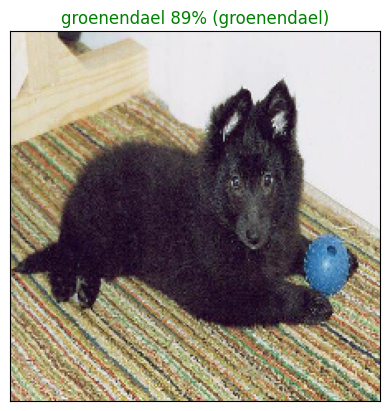

In [56]:
plot_pred(prediction_probabilities=predictions,
         labels=val_labels,
         images=val_images,
         n=77)

Now we've got one function to visualize our models top predictions, lets make another to view our models top ten predictions

The function will:
* Take an input of prediction probabilities array and a ground truth array and an integer (**Done**)
* Find the prediction using `get_pred_label()`(**Done**)
* Find the top 10:
    * Predition probabilities indexes (**Done**)
    * Prediction probabilities values (**Done**)
    * Prediction labels (**Done**)
* Plot the top 10 prediction probability values and labels coloring the true label green (**Done**)


In [57]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
    """
    Plus the top 10 highest prediction confidences along with the truth label for sample n.
    """
    pred_prob, true_label = prediction_probabilities[n], labels[n]
    
    # Get the predicted label
    pred_label  = get_pred_label(pred_prob)
    
    # Find the top 10 prediction confidence indexes
    
    # pred_prob is assumed to be an array containing prediction probabilities for different classes

    # Step 1: Use argsort to get the indices that would sort the array in ascending order
    # This returns an array of indices where the smallest element's index is first and the largest element's index is last
    sorted_indices = pred_prob.argsort()

    # Step 2: Take the last 10 indices from the sorted array to get the indices of the top 10 highest values
    # These are the indices of the 10 largest elements in pred_prob
    top_10_sorted_indices = sorted_indices[-10:]

    # Step 3: Reverse the array to get the indices of the top 10 highest values in descending order
    # This way, the index of the largest value comes first, followed by the second largest, and so on
    top_10_pred_indexes = top_10_sorted_indices[::-1]
    
    # Find the top 10 prediction confidence values
    # This line of code basically takes the indexes of the top 10 values 
    # and returns those top values in descending order
    top_10_pred_values = pred_prob[top_10_pred_indexes]
    
    # Find the top 10 prediction labels
    top_10_pred_labels = unique_breeds[top_10_pred_indexes]
    
    # Setup plot
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                      top_10_pred_values,
                      color="grey")
    plt.xticks(np.arange(len(top_10_pred_labels))
              , labels = top_10_pred_labels,
              rotation="vertical")
    # Change color of true label
    if np.isin(true_label, top_10_pred_labels):
        # Find the index of the true label within the top 10 prediction labels
        # and set the color of the corresponding bar to green
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
    else:
        pass
    
    

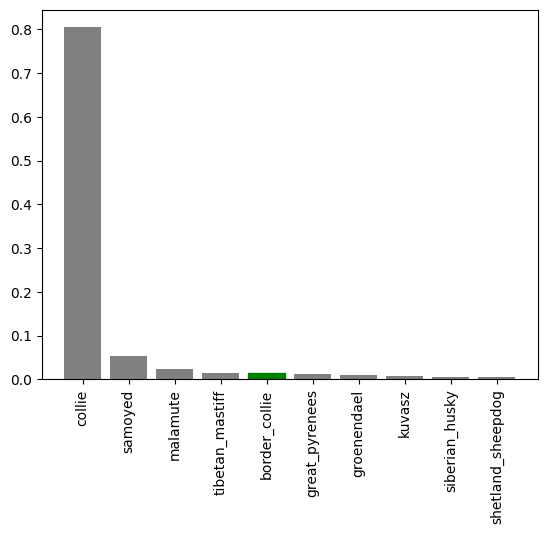

In [58]:
plot_pred_conf(prediction_probabilities=predictions,
              labels=val_labels,
              n=9)

Now we've got some function to help us visualize our predictions and evaluate our model, let's check out a few

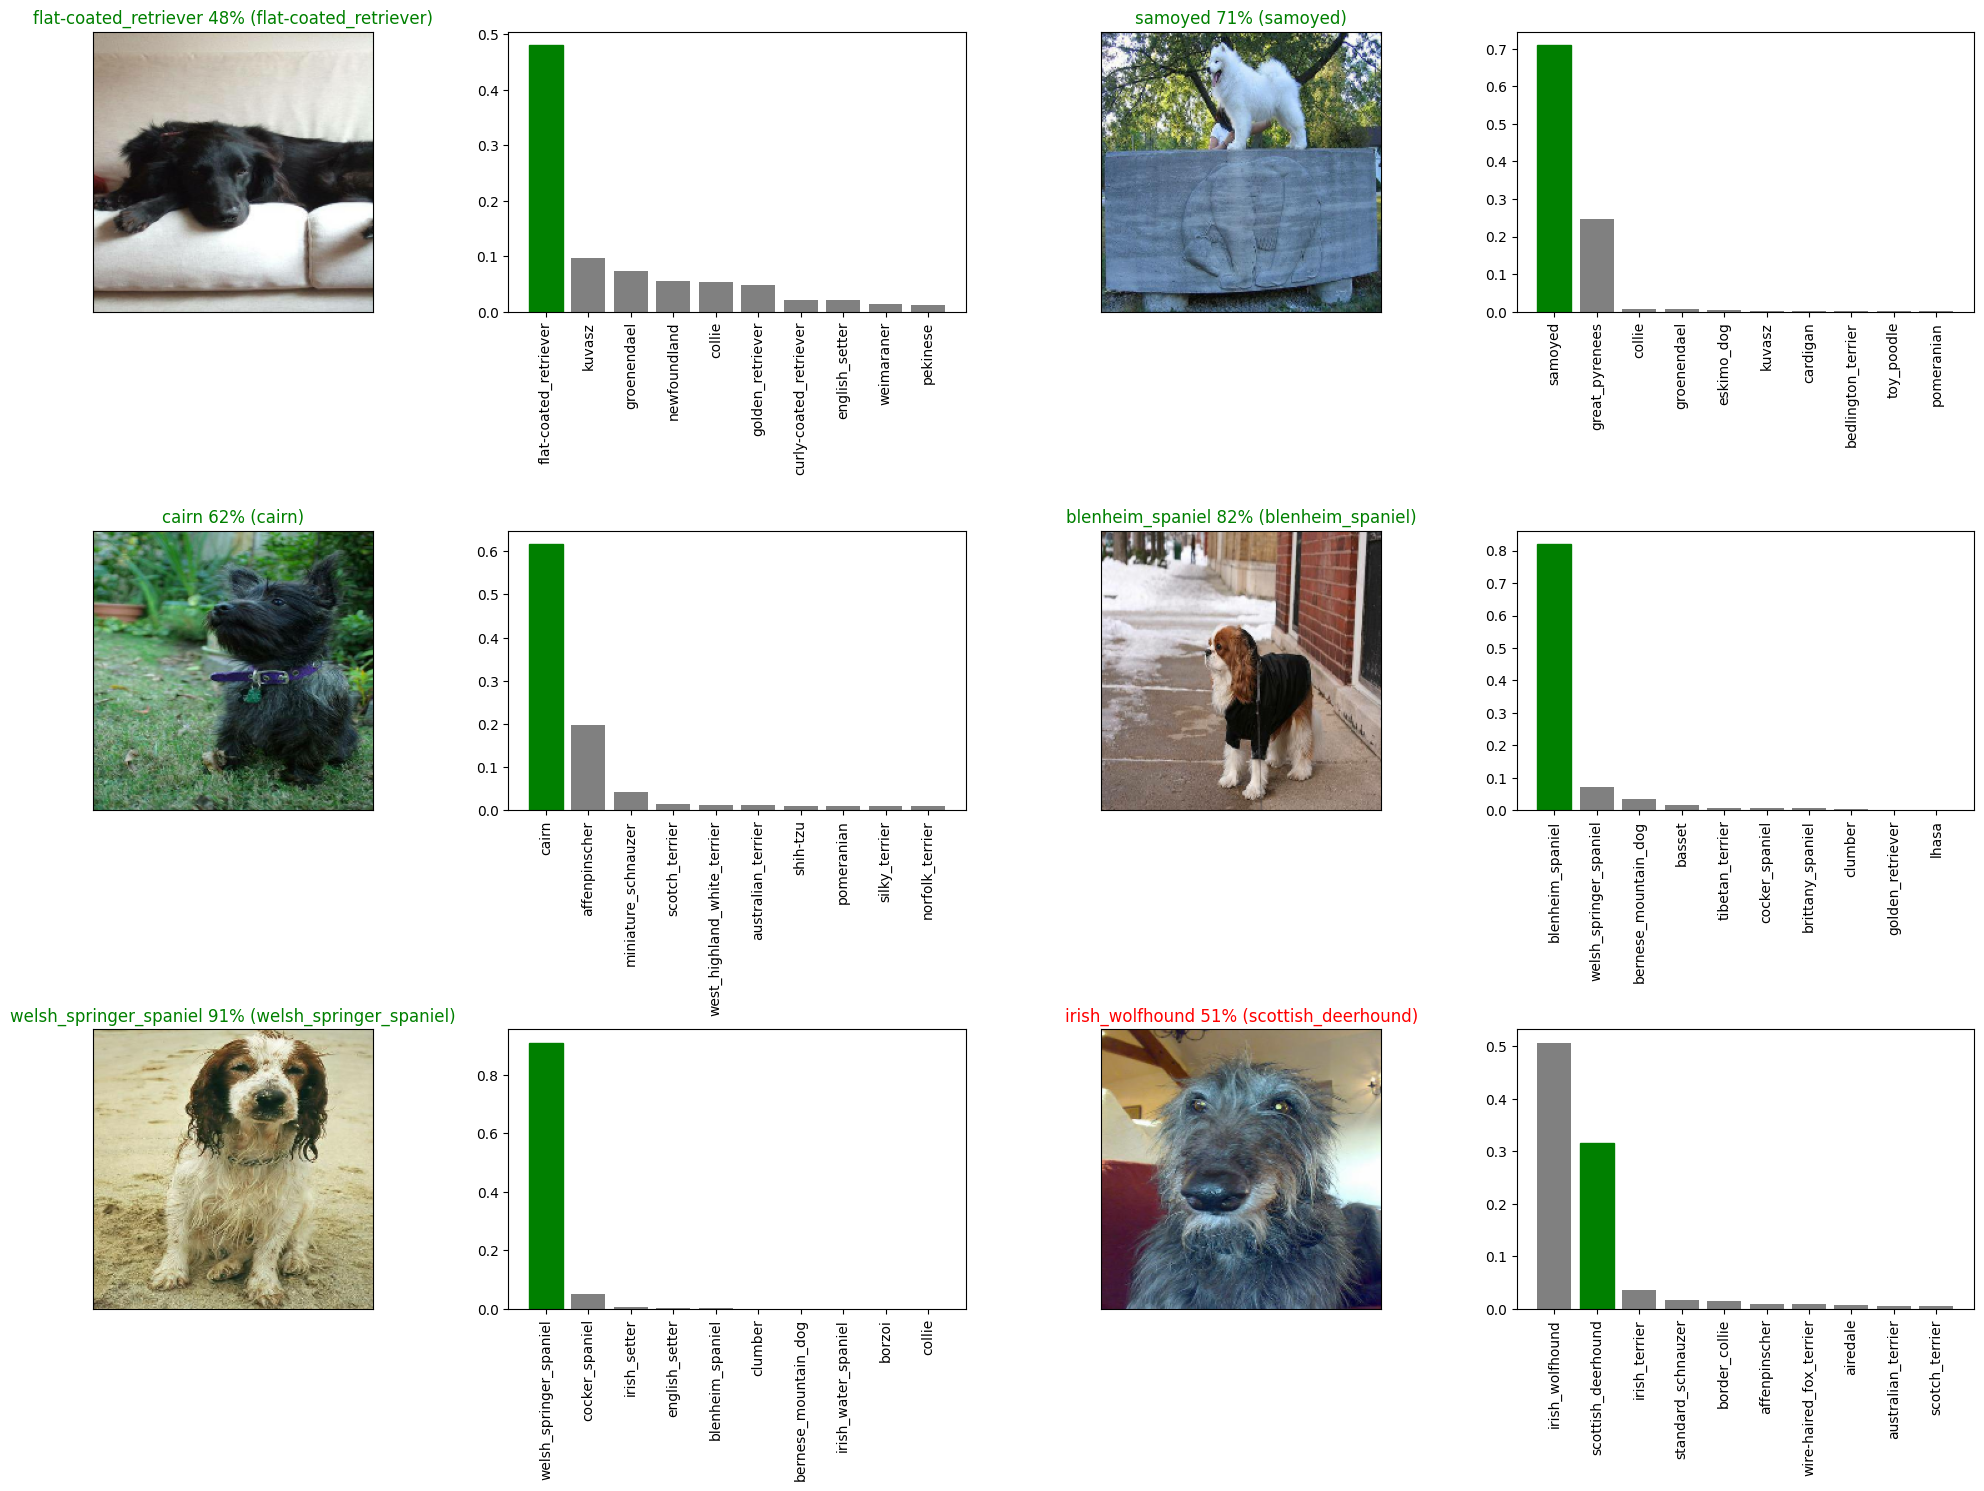

In [59]:
# Number of images to skip before displaying
i_multiplier = 20

# Define the number of rows and columns for the subplot grid
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols  # Total number of images to display

# Set up the figure size for the plot
plt.figure(figsize=(10 * num_cols, 5 * num_rows))

# Loop through the number of images to display
for i in range(num_images):
    # Create a subplot for the image
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_pred(prediction_probabilities=predictions,
              labels=val_labels,
              images=val_images,
              n=i + i_multiplier)
    
    # Create a subplot for the prediction confidence plot
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_pred_conf(prediction_probabilities=predictions,
                   labels=val_labels,
                   n=i + i_multiplier)

# Adjust subplot layout to prevent overlap
plt.tight_layout(h_pad=1.0)

# Display the plot
plt.show()


**Challenge:** How would you create a confusion matrix with our models predictions and true labels?

In [60]:
# Turn prediction probabilities into their respective labels 
def get_pred_labels_all(prediction_probabilities):
    """
    Turns each sample of an array of prediction probabilities into labels.
    """
    return [unique_breeds[np.argmax(prob)] for prob in prediction_probabilities]

# Get predicted labels for all samples in predictions
pred_labels_all = get_pred_labels_all(predictions)
pred_labels_all


['border_terrier',
 'scotch_terrier',
 'basset',
 'bluetick',
 'airedale',
 'bedlington_terrier',
 'keeshond',
 'old_english_sheepdog',
 'saint_bernard',
 'collie',
 'toy_poodle',
 'great_pyrenees',
 'silky_terrier',
 'whippet',
 'english_foxhound',
 'miniature_poodle',
 'irish_setter',
 'african_hunting_dog',
 'labrador_retriever',
 'irish_water_spaniel',
 'flat-coated_retriever',
 'samoyed',
 'cairn',
 'blenheim_spaniel',
 'welsh_springer_spaniel',
 'irish_wolfhound',
 'komondor',
 'cairn',
 'cardigan',
 'dingo',
 'dandie_dinmont',
 'walker_hound',
 'walker_hound',
 'toy_terrier',
 'malamute',
 'malamute',
 'welsh_springer_spaniel',
 'doberman',
 'italian_greyhound',
 'labrador_retriever',
 'labrador_retriever',
 'lakeland_terrier',
 'walker_hound',
 'collie',
 'miniature_poodle',
 'groenendael',
 'boston_bull',
 'miniature_poodle',
 'miniature_poodle',
 'boston_bull',
 'staffordshire_bullterrier',
 'weimaraner',
 'norfolk_terrier',
 'pug',
 'bedlington_terrier',
 'affenpinscher',
 '

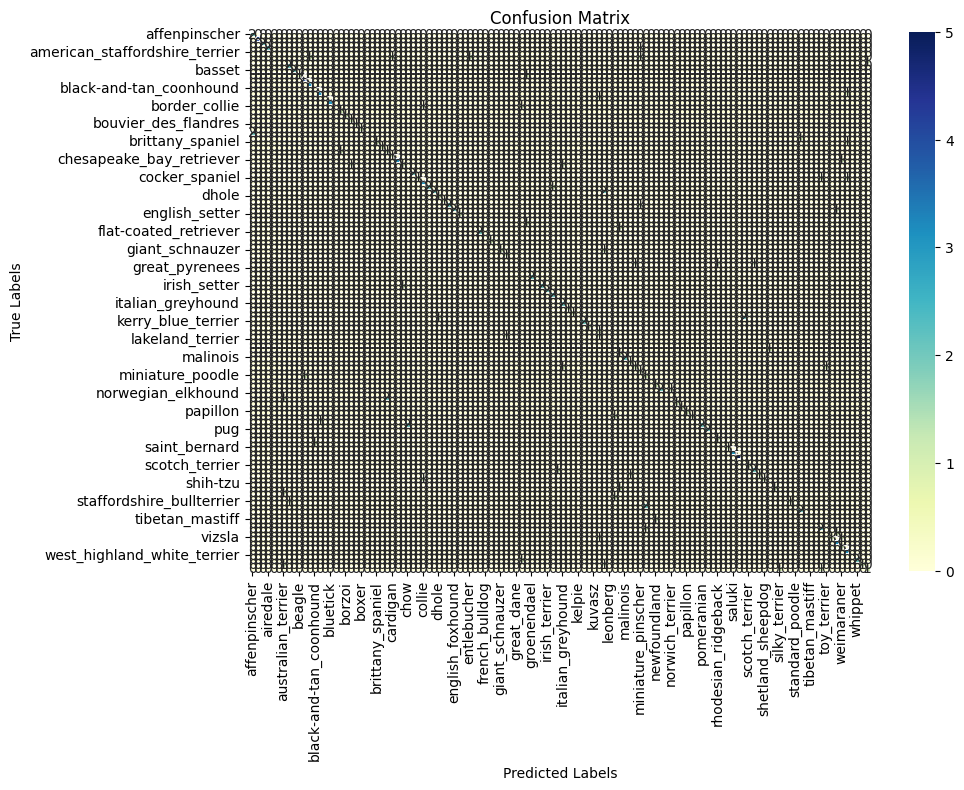

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_labels = np.unique(unique_breeds)  # Complete list of labels

# Computing the confusion matrix
# labels=all_labels because some of the unique breeds might be missing in val_labels
cm = confusion_matrix(val_labels, pred_labels_all, labels=all_labels)

# Create a DataFrame
cm_df = pd.DataFrame(cm, index=all_labels, columns=all_labels)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, 
            linewidths=0.5, 
            fmt= "d", 
            cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Saving and reloading a trained model

In [62]:
import os
import datetime
import tensorflow as tf  # Ensure TensorFlow is imported

def save_model(model, suffix=None):
    """
    Saves a given model in a models directory and appends a suffix (string).
    """
    # Create a model directory pathname with current time
    modeldir = os.path.join("/kaggle/working/models",
                           datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    # Ensure the model directory exists
    os.makedirs(modeldir, exist_ok=True)
    
    # Create the full model path with suffix
    model_path = os.path.join(modeldir, f"model_{suffix}.h5")  # save format of model
    
    print(f"Saving model to {model_path}...")
    
    # Save the model
    model.save(model_path)
    
    return model_path

In [63]:
# Create a function to load a trained model
def load_model(model_path):
    """
    Loads a saved mnodel form a specified path.
    """
    print(f"Loading saved model from:{model_path}")
    model = keras.models.load_model(model_path,
                                      custom_objects={"KerasLayer":hub.KerasLayer})
    return model

Now we've got functions to save and load a trained model, let's make sure they work!

In [64]:
# Save our model trained on 1000 images
model_paths_saved=save_model(model,suffix="100-images-mobilenetv2-Adam")

Saving model to /kaggle/working/models/20240806-082800/model_100-images-mobilenetv2-Adam.h5...


/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [65]:
# Load a trained model
loaded_1000_images_model = load_model(model_paths_saved)

Loading saved model from:/kaggle/working/models/20240806-082800/model_100-images-mobilenetv2-Adam.h5


In [66]:
# evaluate the pre-saed model
model.evaluate(val_data)

7/7 [==============================] - 0s 49ms/step - loss: 1.3247 - accuracy: 0.6500


[1.3246736526489258, 0.6499999761581421]

In [67]:
loaded_1000_images_model.evaluate(val_data)

7/7 [==============================] - 1s 40ms/step - loss: 1.3247 - accuracy: 0.6500


[1.3246736526489258, 0.6499999761581421]

## Training a big dog model (on Full data)

In [68]:
len(X), len(y)

(10222, 10222)

In [69]:
# Create a data batch with the full data set
full_data = create_data_batches(X,y)
full_data

Creating training data batches...


<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [70]:
# Create a model for full model
full_model = create_model()


Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [71]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we cant monitor validation accuracy
full_model_early_stopping = keras.callbacks.EarlyStopping(monitor="accuracy",patience=3)

In [72]:
# Fit the full model to the full data
full_model.fit(x=full_data,
              epochs=NUM_EPOCHS,
              callbacks=[full_model_tensorboard,full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 31s 81ms/step - loss: 1.3455 - accuracy: 0.6721
Epoch 2/100
320/320 [==============================] - 14s 44ms/step - loss: 0.4074 - accuracy: 0.8794
Epoch 3/100
320/320 [==============================] - 14s 44ms/step - loss: 0.2404 - accuracy: 0.9364
Epoch 4/100
320/320 [==============================] - 14s 45ms/step - loss: 0.1538 - accuracy: 0.9622
Epoch 5/100
320/320 [==============================] - 14s 44ms/step - loss: 0.1078 - accuracy: 0.9774
Epoch 6/100
320/320 [==============================] - 14s 45ms/step - loss: 0.0764 - accuracy: 0.9875
Epoch 7/100
320/320 [==============================] - 14s 45ms/step - loss: 0.0590 - accuracy: 0.9919
Epoch 8/100
320/320 [==============================] - 14s 45ms/step - loss: 0.0465 - accuracy: 0.9941
Epoch 9/100
320/320 [==============================] - 14s 45ms/step - loss: 0.0379 - accuracy: 0.9962
Epoch 10/100
320/320 [==============================] - 14s 45ms/step - l

In [74]:
full_model_path_save=save_model(full_model,suffix="full-image-set-mobilenetv2-Adam")

Saving model to /kaggle/working/models/20240806-083304/model_full-image-set-mobilenetv2-Adam.h5...


In [76]:
# Load in the full model
loaded_full_model = load_model(full_model_path_save)

Loading saved model from:/kaggle/working/models/20240806-083304/model_full-image-set-mobilenetv2-Adam.h5


## Making predictions on test data

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format

Luckily we create `create_data_batches()` earlier which can take a list of filenames as input and convert them into Tensor batches.

To make predictions on the test data, we'll:
* Get the test image filenamesn (**Done**)
* Convert the filename into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since the test data doesn't have labels) (**Done**)
* Make a predictions array by passing the test batches to the `predict()` method called on our model.

In [88]:
# Load test image filenames
test_path = "/kaggle/input/drive-02/MyDrive/Dog Vision/dog-breed-identification/test/"
# os.listdir(test_path) gets all the filename from path defined in "test_path" 
# and creates a list and appending each filename with the path defined in "test_path" 
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['/kaggle/input/drive-02/MyDrive/Dog Vision/dog-breed-identification/test/09e51e17e2b756ff2ace8a87bd1443fa.jpg',
 '/kaggle/input/drive-02/MyDrive/Dog Vision/dog-breed-identification/test/f7a32505c12649183c5991ecfa7d68b3.jpg',
 '/kaggle/input/drive-02/MyDrive/Dog Vision/dog-breed-identification/test/bc6d50ffb4644feb34530aa58943e85b.jpg',
 '/kaggle/input/drive-02/MyDrive/Dog Vision/dog-breed-identification/test/7cbc041e79135a572aad87904b5c9c57.jpg',
 '/kaggle/input/drive-02/MyDrive/Dog Vision/dog-breed-identification/test/f3b603f10d6a344f0395fb46b242ff8e.jpg',
 '/kaggle/input/drive-02/MyDrive/Dog Vision/dog-breed-identification/test/db55098d859d27a3c05b0e3fc41d43e7.jpg',
 '/kaggle/input/drive-02/MyDrive/Dog Vision/dog-breed-identification/test/665bab06a3ea861c0812c778486988e3.jpg',
 '/kaggle/input/drive-02/MyDrive/Dog Vision/dog-breed-identification/test/7b57911ea7559cebd6db308125926642.jpg',
 '/kaggle/input/drive-02/MyDrive/Dog Vision/dog-breed-identification/test/df0d6ba158287cb2b3ed64

In [89]:
len(test_filenames)

10357

In [90]:
# Create test data batch
test_data = create_data_batches(test_filenames,test_data=True)

 Creating test data batches...


In [91]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [93]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 13s 41ms/step


In [95]:
# Save predictions (NumPy array) to csv file (for access later)
np.savetxt("/kaggle/working/preds_array_csv",test_predictions, delimiter=",")

In [96]:
load_test_predictions = np.loadtxt("/kaggle/working/preds_array_csv", delimiter=",")
load_test_predictions[:10]

array([[4.36677694e-10, 8.49110224e-13, 2.49248427e-10, ...,
        3.96320047e-06, 4.76056128e-09, 5.29629174e-10],
       [2.21041881e-13, 2.48975146e-10, 3.02700600e-13, ...,
        5.40454570e-09, 3.47891160e-12, 4.18982367e-13],
       [4.03879069e-10, 2.27741566e-05, 1.31637918e-08, ...,
        3.17483170e-07, 3.54625335e-12, 1.78180561e-11],
       ...,
       [3.20749685e-08, 2.24701449e-08, 1.40599624e-11, ...,
        1.68399805e-09, 7.20452344e-14, 1.52452581e-13],
       [5.94038684e-05, 1.68137689e-07, 1.17083141e-06, ...,
        1.71651863e-07, 1.32574387e-05, 1.72917481e-07],
       [5.93159255e-09, 1.46099355e-08, 1.37298894e-09, ...,
        1.08183362e-09, 9.42258910e-11, 1.40362680e-10]])

In [103]:
load_test_predictions.shape

(10357, 120)

# Preparing test dataset predictions for kaggle

Looking at the Kaggle sample submission, we find that it wants our models prediction probability outputs in a DataFrame with an ID column and a column for each different dog breed.
www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

To get the data in this format, we'll:
* Create a pandas DataFrame with an ID column as well as a column for each dog breed (**Done**)
* Add data to the ID column by extracting the test image ID's from their filepaths
* Add data (the prediction probabilities) to each of the dog breed columns.
* Export the DataFrame as a CSV to submit it to Kaggle


In [98]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"]+list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [102]:
# Append test images ID's to predictions DataFrame
# splitext()[0] just extracts the filename without file extension
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids
preds_df.head()

id affenpinscher afghan_hound  \
0  09e51e17e2b756ff2ace8a87bd1443fa           NaN          NaN   
1  f7a32505c12649183c5991ecfa7d68b3           NaN          NaN   
2  bc6d50ffb4644feb34530aa58943e85b           NaN          NaN   
3  7cbc041e79135a572aad87904b5c9c57           NaN          NaN   
4  f3b603f10d6a344f0395fb46b242ff8e           NaN          NaN   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 NaN      NaN                            NaN         NaN   
1                 NaN      NaN                            NaN         NaN   
2                 NaN      NaN                            NaN         NaN   
3                 NaN      NaN                            NaN         NaN   
4                 NaN      NaN                            NaN         NaN   

  australian_terrier basenji basset  ... toy_poodle toy_terrier vizsla  \
0                NaN     NaN    NaN  ...        NaN         NaN    NaN   
1                NaN     NaN    NaN  ...        NaN         NaN    NaN   
2                NaN     NaN    NaN  ...        NaN         NaN    NaN   
3                NaN     NaN    NaN  ...        NaN         NaN    NaN   
4                NaN     NaN    NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   
2          NaN        NaN                    NaN                         NaN   
3          NaN        NaN                    NaN                         NaN   
4          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  
2     NaN                     NaN               NaN  
3     NaN                     NaN               NaN  
4     NaN                     NaN               NaN  

[5 rows x 121 columns]

In [104]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = load_test_predictions
preds_df.head()

id  affenpinscher  afghan_hound  \
0  09e51e17e2b756ff2ace8a87bd1443fa   4.366777e-10  8.491102e-13   
1  f7a32505c12649183c5991ecfa7d68b3   2.210419e-13  2.489751e-10   
2  bc6d50ffb4644feb34530aa58943e85b   4.038791e-10  2.277416e-05   
3  7cbc041e79135a572aad87904b5c9c57   1.805360e-10  6.063839e-12   
4  f3b603f10d6a344f0395fb46b242ff8e   9.469306e-13  1.756565e-11   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         2.492484e-10  1.613468e-09                    4.155927e-02   
1         3.027006e-13  7.151266e-11                    5.757046e-10   
2         1.316379e-08  2.288598e-07                    3.587823e-08   
3         1.532643e-12  4.373886e-09                    1.945622e-06   
4         1.674179e-12  2.292267e-09                    3.667306e-12   

    appenzeller  australian_terrier       basenji        basset  ...  \
0  1.627490e-10        6.444176e-08  9.855251e-08  2.757391e-11  ...   
1  2.647376e-10        1.898473e-09  8.102864e-10  6.731353e-09  ...   
2  1.045407e-09        7.248656e-11  2.862539e-10  9.014279e-09  ...   
3  1.759240e-07        1.380266e-09  1.526172e-10  2.799342e-12  ...   
4  3.300185e-09        3.763045e-10  1.807905e-11  3.638571e-09  ...   

     toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0  1.743917e-08  5.113892e-07  1.980568e-09  1.678325e-08  4.237544e-11   
1  1.567298e-11  1.518363e-12  1.129408e-06  1.080071e-07  9.111345e-12   
2  2.363700e-10  7.676119e-12  6.399708e-12  6.887313e-09  1.887220e-08   
3  1.567056e-09  1.713375e-08  2.543209e-10  1.896944e-10  2.208993e-04   
4  7.760172e-13  9.854811e-12  1.181829e-10  9.611888e-11  3.208945e-13   

   welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0            8.736710e-13                 1.075071e-08  3.963200e-06   
1            1.966363e-12                 1.100356e-14  5.404546e-09   
2            3.106434e-09                 4.822743e-12  3.174832e-07   
3            1.447387e-12                 1.830442e-11  1.657721e-05   
4            9.999714e-01                 3.003692e-11  4.166464e-13   

   wire-haired_fox_terrier  yorkshire_terrier  
0             4.760561e-09       5.296292e-10  
1             3.478912e-12       4.189824e-13  
2             3.546253e-12       1.781806e-11  
3             4.818344e-10       9.629748e-10  
4             2.212177e-12       3.631805e-12  

[5 rows x 121 columns]

In [105]:
# save our predictions dataframe to CSV for sumbission to kaggle
preds_df.to_csv("/kaggle/working/full_model_predictions_submission_1_mobilenetV2.csv",index=False)

## Making predictions on Custom images

To make predictions on custom images, we'll:
* Get teh filepath of our own images.
* Turn the filepaths into data batches using `create_data_batches()`, And since our custom images won't have labels, we set the `test_data` parameter to `True`
* Pass the custom image data batch to ur model's `predict()`
* Convert the prediction output probabilities to predictions labels.
* Compare the predicted labels to the custom images.

In [106]:
# Get custom image filepaths
custom_path = "/kaggle/input/custom-dog-photos/my-dog-photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]c

In [108]:
custom_image_paths

['/kaggle/input/custom-dog-photos/my-dog-photos/dog-1742295_1280.jpg',
 '/kaggle/input/custom-dog-photos/my-dog-photos/dog-8439530_1280.jpg',
 '/kaggle/input/custom-dog-photos/my-dog-photos/dog-3277416_1280.jpg']

In [110]:
# Turn custom images into batch dataset
custom_data = create_data_batches(custom_image_paths,test_data=True)
custom_data

 Creating test data batches...


<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [111]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

1/1 [==============================] - 1s 996ms/step


In [112]:
custom_preds.shape

(3, 120)

In [113]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['weimaraner', 'bull_mastiff', 'vizsla']

In [115]:
# Get custom images (our unbatchify() function won't work since there aren't labels... maybe we could fix this later)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
    custom_images.append(image)

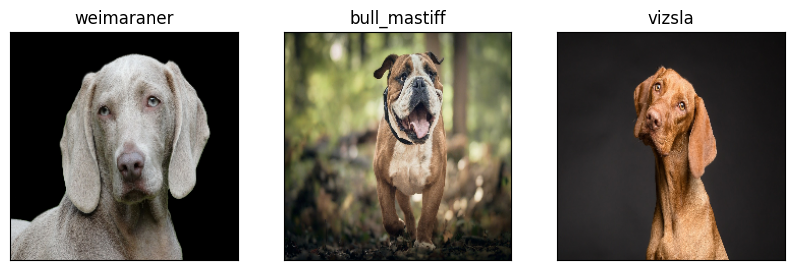

In [118]:
# Check custom image predictions
plt.figure(figsize=(10,10))
for i,image in enumerate(custom_images):
    plt.subplot(1,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(custom_pred_labels[i])
    plt.imshow(image)